<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Korgun Dmitry, @tbb
    
## <center> Tutorial
### <center> "Something else about ensemble learning"

The goal behind ensemble methods is to combine different classifiers into a meta-classifier that has a better generalization performance than each individual classifier alone. For example, assuming that we collected prediction from 10 different kaggle-kernels, ensemble method would allow us to combine these predictions to come up with a prediction that is more accurate and robust than the prediction by one each kernel. There are several ways to create an ensemble of classifiers each aimed for own purpose:

* **Bagging** - decrease the variance
* **Boosting** - decrease the bias
* **Stacking** - improve the predictive force

What is "bagging" and "boosting" you already know from lectures, but let me remind you main ideas.

**_Bagging_** - generate additional data for training from the original dataset using combinations with repetitions to produce multisets of the same size as the original dataset. By increasing the size of training set you can't improve the model predictive force, but just decrease the variance, narrowly tuning the prediction to the expected outcome.

**_Boosting_** - two-step approach, where first uses subsets of the original data to produce a series of averagely performing models and then "boosts" their performance by combining them together using a particular cost function (e.g. majority vote). Unlike bagging, in the classical boosting the subset creation is not random and depends upon the performance of the previous models: every new subset contains the elements that were misclassified by the previous model.

**_Stacking (Blending)_ ** -  is similar to boosting: you also apply several models to your original data. The difference here is that you don't have an empirical formula for your weight function, rather you introduce a meta-level and use another model/approach to estimate the input together with outputs of every model to estimate the weights, in other words, to determine what models perform well and what badly given these input data.

### Intro
Before we start, I guess, we should see a graph that demonstrates the relationship between the ensemble and individual classifier error. In other words, this graph visualizes the Condorcet’s jury theorem.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import comb
from itertools import product

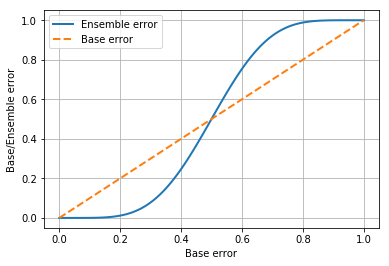

In [2]:
# calculate ensemble error
def ensemble_error(n_clf, error):
    k_start = math.ceil(n_clf / 2)
    probs = [comb(n_clf, k) * error ** k * (1 - error) ** (n_clf - k)
             for k in range(k_start, n_clf + 1)]
    return sum(probs)

error_range = np.arange(0.0, 1.01, .01)
errors = [ensemble_error(n_clf=11, error=error)
          for error in error_range]

plt.plot(error_range, errors,
         label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='best')
plt.grid()
plt.show()

As we can see, the error probability of an ensemble is always better than the error of an individual classifier as long as the classifier performs better than random guessing.

Let's start with a warm-up exercise and implement a simple ensemble classifier for majority voting like an example of simplest ensemble algorithm.

In [14]:
# import some useful stuff
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, _name_estimators
from sklearn.model_selection  import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [28]:
# and make a small helper function to plot classifiers decision area
def plot_clf_area(classifiers, labels,
                  X, s_row=2, s_col=2, 
                  scaling=True,
                  colors=None,
                  markers=None):
    if not colors:
        colors = ['green', 'red', 'blue']
        
    if not markers:
        markers = ['^', 'o', 'x']
        
    if scaling:
        sc = StandardScaler()
        X_std = sc.fit_transform(X)

    # find plot boundaries
    x_min = X_std[:, 0].min() - 1
    x_max = X_std[:, 0].max() + 1
    y_min = X_std[:, 1].min() - 1
    y_max = X_std[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    f, axarr = plt.subplots(nrows=s_row, ncols=s_col,
                            sharex='col',
                            sharey='row',
                            figsize=(12, 8))
    for idx, clf, tt in zip(product(range(s_row), range(s_col)),
                            classifiers, labels):
        clf.fit(X_std, y_train)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=.3)

        for label, color, marker in zip(np.unique(y_train), colors, markers):
            axarr[idx[0], idx[1]].scatter(X_std[y_train==label, 0],
                                          X_std[y_train==label, 1],
                                          c=color,
                                          marker=marker,
                                          s=50)
        axarr[idx[0], idx[1]].set_title(tt)

### Implementing a simple majority vote classifier

In [23]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A Majority vote ensemble classifier
    
    Params
    -----
    classifiers : array, shape = [n_classifiers]
        Classifiers for the ensemble
      
    vote : str, {'label', 'probability'}
        Default: 'label'
        If 'label' the prediction based on the argmax
        of class labels. Else if 'probability', the
        argmax of the sum of probabilities is used to
        predict the class label.
      
    weights : array, shape = [n_classifiers]
        Optional, default: None
        If a list of 'int' or 'float' values are provided,
        the classifiers are weighted by importance;
        Uses uniform weights if 'None'
    """    
    def __init__(self, classifiers,
                 vote='label', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value 
                                  for key, value 
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Fit classifiers.
        
        Params
        -----
        X : {array, matrix}
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array, shape = [n_samples]
            Vector of target labels.
        """
        
        # Use LabelEncoder to ensure class labels start with 0
        # which is important for np.argmax call in self.predict
        self.le_ = LabelEncoder()
        self.le_.fit(y)
        self.classes_ = self.le_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.le_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Params
        -----
        X : {array, matrix}
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        Returns
        -----
        maj_vote : array, shape = [n_samples]
            Predicted class labels.
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x, weights=self.weights)),
                                           axis=1,
                                           arr=predictions)
        
        maj_vote = self.le_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.

        Params
        -----
        X : {array, matrix}
            shape = [n_samples, n_features]
            Training vectors, where n_samples is the number
            of samples and n_features the number of features.

        Returns
        -----
        avg_proba : array
            shape = [n_samples, n_classes]
            Weighted average probability for each class per sample
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

Parent classes **_BaseEstimator_** and **_ClassifierMixin_** give some some base functionality like *get_params* and *set_params* for free.

Now it's time to test out classifier.

In [10]:
# load data
wine = datasets.load_wine()
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [9]:
# use only two feature - alco & hue
X, y = wine.data[:, [0, 10]], wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3, random_state=11)

ROC AUC: 0.85 (+/- 0.09 Logistic Regresion)
ROC AUC: 0.85 (+/- 0.09 Decision Tree)
ROC AUC: 0.85 (+/- 0.08 KNN)
ROC AUC: 0.88 (+/- 0.06 Majority Vote)


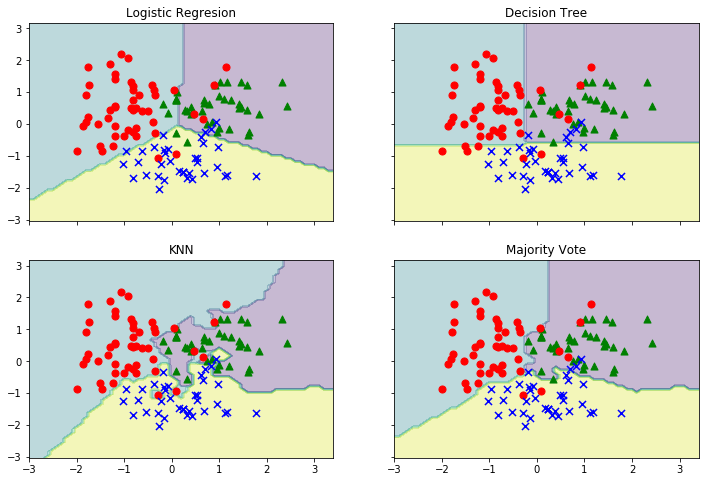

In [29]:
# make base classifiers
clf1 = LogisticRegression(penalty='l2', C=.001, random_state=11)
clf2 = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=11)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# LR and KNN use Euclidian distance metric so need to scale the data
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

labels = ['Logistic Regresion', 'Decision Tree', 'KNN', 'Majority Vote']

all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10)
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f} {label})')


plot_clf_area(all_clf, labels, X_train)
plt.show()

As we can see, the perfomance of the MajorityVotingClassifier gas substabtially improved over the individual classifiers in the 10-fold cross-validation evaluation. Note that the decicion regions of the ensemble classifier seem to be a hybrid of the decision regions from the individual classifiers. 

### Stacking
The majority vote approach similar to stacking. However, the stacking algorithm used in combination with a model that predicts the final class label using the predictions of the individual classifiers in the ensemble as input.

The basic idea behind stacked generalization is to use a pool of base classifiers, then using another classifier, that called meta-classifier, to combine their predictions, with the aim of reducing the generalization error.

Let’s say you want to do 2-fold stacking:

* Split the train set in 2 parts: train_a and train_b
* Fit a first-stage model on train_a and create predictions for train_b
* Fit the same model on train_b and create predictions for train_a
* Finally fit the model on the entire train set and create predictions for the test set.
* Now train a second-stage stacker model on the probabilities from the first-stage model(s).

We will use only meta features and 1-block validation. You can easily add the necessary functionality if you need.
Let implement Stacking based on the MajorityVoteClassifier class. 

In [30]:
class StackingClassifier(BaseEstimator, ClassifierMixin):
    """A Stacking classifier for scikit-learn estimators for classification.
    
    Params
    -----
    classifiers : array, shape = [n_classifiers]
        A list of classifiers for stacking.
    meta_classifier : object
        The meta-classifier to be fitted on the ensemble of
        classifiers
    use_probas : bool (default: True)
        If True, trains meta-classifier based on predicted probabilities
        instead of class labels.
    average_probas : bool (default: True)
        Averages the probabilities as meta features if True.

    """
    def __init__(self, classifiers, meta_classifier,
                 use_probas=True, average_probas=True):

        self.classifiers = classifiers
        self.meta_classifier = meta_classifier
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.named_meta_classifier = {f'meta-{key}' : value for
                                      key, value in _name_estimators([meta_classifier])}
        self.use_probas = use_probas
        self.average_probas = average_probas

    def fit(self, X, y):
        """ Fit ensemble classifers and the meta-classifier.
        
        Params
        -----
        X : {array, matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array, shape = [n_samples] or [n_samples, n_outputs]
            Target values.
        """
        self.classifiers_ = [clone(clf) for clf in self.classifiers]
        self.meta_clf_ = clone(self.meta_classifier)

        for clf in self.classifiers_:
            clf.fit(X, y)

        meta_features = self.predict_meta_features(X)
        self.meta_clf_.fit(meta_features, y)
        return self

    def predict(self, X):
        """ Predict target values for X.
        Params
        -----
        X : {array, matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -----
        labels : array, shape = [n_samples] or [n_samples, n_outputs]
            Predicted class labels.
        """
        meta_features = self.predict_meta_features(X)

        return self.meta_clf_.predict(meta_features)

    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Params
        -----
        X : {array, matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -----
        proba : array, shape = [n_samples, n_classes] or a list of \
                n_outputs of such arrays if n_outputs > 1.
            Probability for each class per sample.
        """
        meta_features = self.predict_meta_features(X)

        return self.meta_clf_.predict_proba(meta_features)
    
    def predict_meta_features(self, X):
        """ Get meta-features of test-data.
        Params
        -----
        X : array, shape = [n_samples, n_features]
            Test vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -----
        meta-features : array, shape = [n_samples, n_classifiers]
            Returns the meta-features for test data.
        """
        if self.use_probas:
            probas = np.asarray([clf.predict_proba(X)
                                 for clf in self.classifiers_])
            if self.average_probas:
                vals = np.average(probas, axis=0)
            else:
                vals = np.concatenate(probas, axis=1)
        else:
            vals = np.column_stack([clf.predict(X) for clf in self.classifiers_])
        return vals
    
    def get_params(self, deep=True):
        """Return estimator parameter names for GridSearch support."""

        if not deep:
            return super(StackingClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value

            out.update(self.named_meta_classifier.copy())
            for name, step in self.named_meta_classifier.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value

            for key, value in super(StackingClassifier,
                                    self).get_params(deep=False).items():
                out[f'{key}'] = value

            return out

Usually, **_LogisticRegression_** is used as a meta-model and we will not change the tradition. Let's check StackingClassifier.

ROC AUC: 0.86 (+/- 0.09 Logistic Regresion C=0.1)
ROC AUC: 0.85 (+/- 0.08 Logistic Regresion C=1)
ROC AUC: 0.85 (+/- 0.08 Logistic Regresion C=10)
ROC AUC: 0.64 (+/- 0.05 Decision Tree depth=1)
ROC AUC: 0.85 (+/- 0.09 Decision Tree depth=2)
ROC AUC: 0.86 (+/- 0.09 Decision Tree depth=3)
ROC AUC: 0.85 (+/- 0.08 KNN 1)
ROC AUC: 0.87 (+/- 0.08 KNN 2)
ROC AUC: 0.89 (+/- 0.07 Stacking)


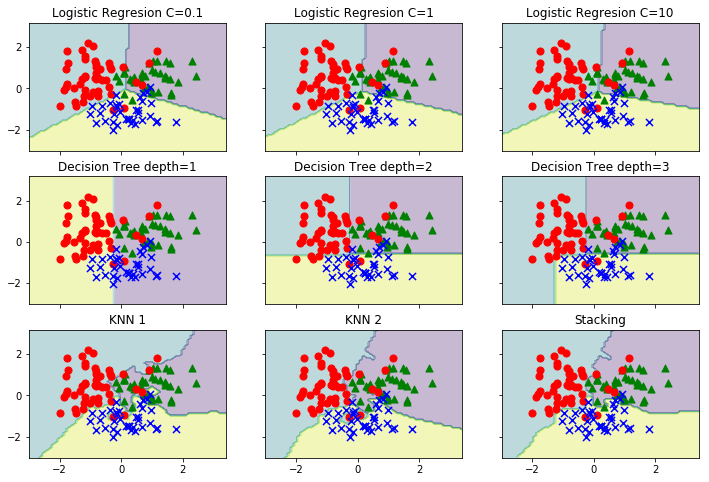

In [33]:
# make base LR classifiers
lr1 = LogisticRegression(C=.1, random_state=11)
lr2 = LogisticRegression(C=1, random_state=11)
lr3 = LogisticRegression(C=10, random_state=11)

# make base DT classifiers
dt1 = DecisionTreeClassifier(max_depth=1, random_state=11)
dt2 = DecisionTreeClassifier(max_depth=2, random_state=11)
dt3 = DecisionTreeClassifier(max_depth=3, random_state=11)

# make base KNN classifiers
knn1 = KNeighborsClassifier(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=2)

# scale data for metrics classifiers
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', lr1]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['clf', lr2]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', lr3]])
pipe4 = Pipeline([['sc', StandardScaler()],
                  ['clf', knn1]])
pipe5 = Pipeline([['sc', StandardScaler()],
                  ['clf', knn2]])
clfs = [pipe1, pipe2, pipe3, dt1, dt2, dt3, pipe4, pipe5]

# make meta classifiers
meta_clf = LogisticRegression(random_state=11)
stacking = StackingClassifier(classifiers=clfs,
                              meta_classifier=meta_clf)

labels = [
    'Logistic Regresion C=0.1',
    'Logistic Regresion C=1',
    'Logistic Regresion C=10',
    'Decision Tree depth=1',
    'Decision Tree depth=2',
    'Decision Tree depth=3',
    'KNN 1',
    'KNN 2',
    'Stacking',
]

clfs = clfs + [stacking]

for clf, label in zip(clfs, labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10)
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f} {label})')

plot_clf_area(clfs, labels, X_train, s_row=3, s_col=3)
plt.show()

### Blending
Blending is a word introduced by the Netflix winners. It is very close to stacked generalization, but a bit simpler and less risk of an information leak. Some researchers use “stacked ensembling” and “blending” interchangeably.

With blending, instead of creating out-of-fold predictions for the train set, you create a small holdout set of say 10% of the train set. The stacker model then trains on this holdout set only.

Blending has a few benefits:

* It is simpler than stacking.
* It wards against an information leak: The generalizers and stackers use different data.

The cons are:
* You use less data overall
* The final model may overfit to the holdout set.

### Summary

Ensemble methods combine different classification models to cancel out their individual weakness, which often results in stable and well-performing models that are very attractive for machine learning competitions and sometimes for industrial applications too.

### Resources

1. [Ensemble Learning to Improve Machine Learning Results](https://blog.statsbot.co/ensemble-learning-d1dcd548e936)
2. [KAGGLE ENSEMBLING GUIDE](https://mlwave.com/kaggle-ensembling-guide/)
3. [The BigChaos Solution to the Netflix Grand Prize](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)
4. [Feature-Weighted Linear Stacking](https://arxiv.org/pdf/0911.0460.pdf)
5. [Stacking example](https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb)
6. [A Kaggler's Guide to Model Stacking in Practice](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)